# 1D CNN

In [1]:
from torch.utils.data import DataLoader

from utils import *
from matplotlib import pyplot
import os
from pdb import set_trace
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(device)

cpu


In [3]:
torch.set_default_dtype(torch.float64)
# Load data
path = './intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData, actTimeTrain, actTimeTest  = fileReader(path, 100, 0.8)
print('Data loading from files - complete')

VmTrainData = (VmTrainData - torch.min(VmTrainData))/(torch.max(VmTrainData) - torch.min(VmTrainData))
pECGTrainData = (pECGTrainData - torch.min(pECGTrainData))/(torch.max(pECGTrainData) - torch.min(pECGTrainData))

VmDataTest = (VmDataTest - torch.min(VmDataTest))/(torch.max(VmDataTest) - torch.min(VmDataTest))

pECGTestData = (pECGTestData - torch.min(pECGTestData))/(torch.max(pECGTestData) - torch.min(pECGTestData))
print('Normalization - complete!')

Loading datafiles : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.63it/s]

Data loading from files - complete
Normalization - complete!


# SqueezeNet

In [4]:
import torch.nn as nn
import math 

class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv1d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv1d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv1d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
            ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', dropout = 0.5, kernel_size = 3):
        super(SqueezeNet, self).__init__()
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv1d(12, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool1d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool1d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':  # PAPER
            self.features = nn.Sequential(
                nn.Conv1d(12, 64, kernel_size=kernel_size, stride=1, padding = 1 + math.ceil((kernel_size-3)/2) ),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=kernel_size, stride=1, padding = 1 + math.ceil((kernel_size-3)/2), ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool1d(kernel_size=kernel_size, stride=1, padding = 1 + math.floor((kernel_size-3)/2), ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool1d(kernel_size=kernel_size, stride=1, padding = 1 + math.floor((kernel_size-3)/2), ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256)
            )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv1d(512, 75, kernel_size=1, padding = 0)
        self.classifier = nn.Sequential(
            nn.Dropout(p = dropout),
            final_conv
        )
    
        #Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [5]:
model = SqueezeNet(version='1_1')

In [6]:
learning_rate = 1e-3
gamma_scheduler = 1.0
step_size_scheduler = 100
batch_size = 32
num_epochs = 10
grad_clippling = False
dropout = 0.0
loss_norm = MSE
load_model = False
model_path = ./mymodel.training.epoch.1400.pth

SyntaxError: invalid syntax (2548709406.py, line 10)

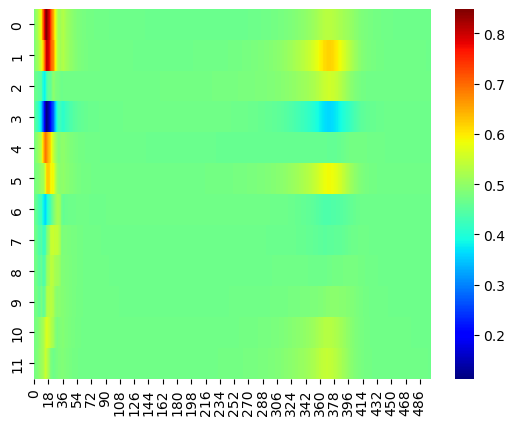

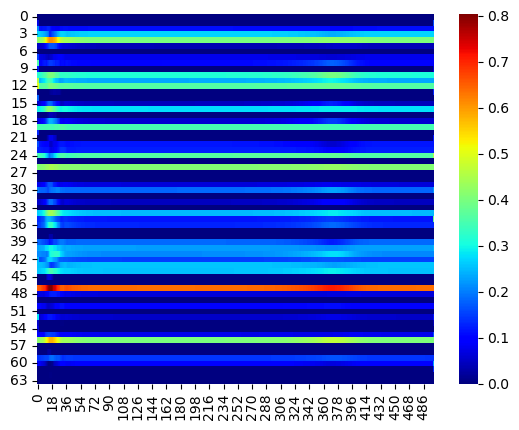

In [63]:
cmap='jet'
sns.heatmap(x.squeeze(0).detach(), cmap=cmap);plt.show()
sns.heatmap(maxpool_0(relu_0(conv0_0(x))).squeeze(0).detach(), cmap=cmap);plt.show()